# Flash drought study area plot

In [1]:
import glob as glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/g/data/mn51/users/jb6465/code/flash-drought/attribution-python')
from attribution import *
from plotting import *
from extract import *

In [3]:
cd /g/data/mn51/users/jb6465/code/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/code/drought-github/submodules/plotting_maps


In [4]:
from acs_area_statistics import *
from acs_plotting_maps import *
import glob
import logging
(logging.getLogger('flox')).setLevel(logging.WARNING)

In [5]:
agcd_pr_dir = '/g/data/zv2/agcd/v1-0-2/precip/total/r005/01month'
agcd_tasmax_dir = '/g/data/zv2/agcd/v1-0-2/tmax/mean/r005/01month'
agcd_tasmin_dir = '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01month'

In [6]:
agcd_pr_cube = xr.open_mfdataset(sorted([agcd_file for agcd_file in glob.glob(f"{agcd_pr_dir}/*.nc") if any(str(year) in agcd_file for year in range(1965, 2015))]))
agcd_tasmax_cube = xr.open_mfdataset(sorted([agcd_file for agcd_file in glob.glob(f"{agcd_tasmax_dir}/*.nc") if any(str(year) in agcd_file for year in range(1965, 2015))]))
agcd_tasmin_cube = xr.open_mfdataset(sorted([agcd_file for agcd_file in glob.glob(f"{agcd_tasmin_dir}/*.nc") if any(str(year) in agcd_file for year in range(1965, 2015))]))
agcd_tasmean_cube = agcd_tasmax_cube.drop_vars('tmax').assign(tmean=(agcd_tasmax_cube['tmax'] + agcd_tasmin_cube['tmin']) / 2)

In [7]:
agcd_pr = agcd_pr_cube.groupby('time.month').mean(dim='time').assign_coords({"lat":agcd_pr_cube.lat.astype("double").round(2), "lon":agcd_pr_cube.lon.astype("double").round(2)})
agcd_tasmax = agcd_tasmax_cube.groupby('time.month').mean(dim='time').assign_coords({"lat":agcd_tasmax_cube.lat.astype("double").round(2), "lon":agcd_tasmax_cube.lon.astype("double").round(2)})
agcd_tasmin = agcd_tasmin_cube.groupby('time.month').mean(dim='time').assign_coords({"lat":agcd_tasmin_cube.lat.astype("double").round(2), "lon":agcd_tasmin_cube.lon.astype("double").round(2)})
agcd_tasmean = agcd_tasmean_cube.groupby('time.month').mean(dim='time').assign_coords({"lat":agcd_tasmean_cube.lat.astype("double").round(2), "lon":agcd_tasmean_cube.lon.astype("double").round(2)})

In [8]:
gdf = gpd.read_file(("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/nrm_regions/nrm_regions.shp"))
gdf = gdf.dissolve(by="ClusterAb").reset_index()
gdf.iloc[[3, 5]] = gdf.iloc[[5, 3]].values
gdf.iloc[[-2, -1]] = gdf.iloc[[-1, -2]].values
regions = regionmask.from_geopandas(gdf, names= "ClusterAb",overlap=True) #get_regions(["nrm_regions"])
mask_frac = regions.mask_3D_frac_approx(agcd_pr['precip'][0])
dims = ("lat", "lon",)

In [9]:
gdf

,ClusterAb,geometry,SubClusNm,SubClusAb,ClusterNm,SupClusNm,SupClusAb
0,CS,"POLYGON ((147.957 -24.87855, 147.95711 -24.878...",Central Slopes,CS,Central Slopes,Eastern Australia,EA
1,EC,"MULTIPOLYGON (((153.53442 -28.17702, 153.53471...",East Coast (South),ECS,East Coast,Eastern Australia,EA
2,MB,"POLYGON ((145.74765 -32.21733, 145.75054 -32.2...",Murray Basin,MB,Murray Basin,Southern Australia,SA
3,SS,"MULTIPOLYGON (((147.0437 -43.31381, 147.04111 ...",Southern Slopes (Vic/NSW East),SSVE,Southern Slopes,Southern Australia,SA
4,R,"POLYGON ((114.14357 -22.538, 114.14296 -22.538...",Rangelands (North),RN,Rangelands,Rangelands,R
5,MN,"POLYGON ((146.29742 -18.90381, 146.29992 -18.9...",Monsoonal North (East),MNE,Monsoonal North,Northern Australia,NA
6,WT,"MULTIPOLYGON (((148.46219 -20.06725, 148.46352...",Wet Tropics,WT,Wet Tropics,Northern Australia,NA
7,SSWF,"MULTIPOLYGON (((139.35429 -33.09761, 139.35429...",Southern and South Western Flatlands (West),SSWFW,Southern and South Western Flatlands,Southern Australia,SA


In [10]:
pr_df = acs_regional_stats(ds=agcd_pr,var='precip', mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe().pivot_table(index='month', columns='region', values='precip_mean', aggfunc='sum')
tasmax_df = acs_regional_stats(ds=agcd_tasmax,var='tmax', mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe().pivot_table(index='month', columns='region', values='tmax_mean', aggfunc='mean')
tasmin_df = acs_regional_stats(ds=agcd_tasmin,var='tmin', mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe().pivot_table(index='month', columns='region', values='tmin_mean', aggfunc='mean')
tasmean_df = acs_regional_stats(ds=agcd_tasmean,var='tmean', mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe().pivot_table(index='month', columns='region', values='tmean_mean', aggfunc='mean')

In [11]:
barraR2_dir = '/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/'
barra_topo = xr.open_dataset(f'{barraR2_dir}fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc')

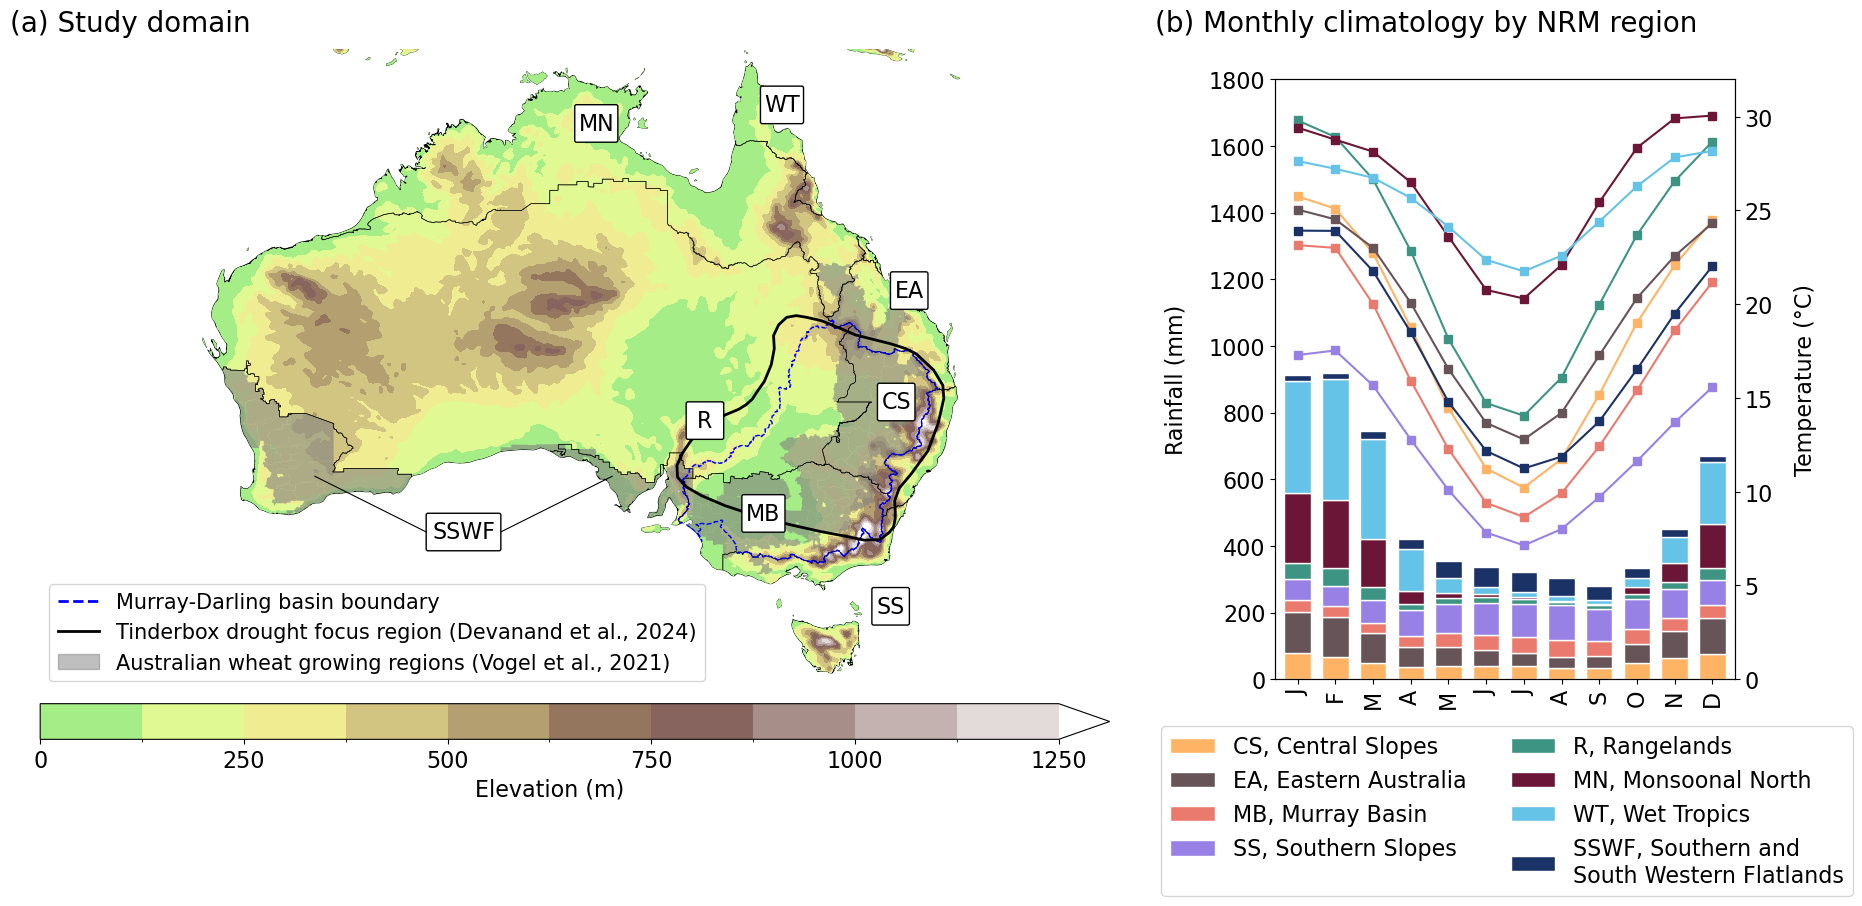

<Figure size 640x480 with 0 Axes>

In [12]:
from cartopy.feature import ShapelyFeature
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

# q_mask = np.ma.masked_greater(xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1960_2022fraction_ge1.nc").fraction.interp_like(xr.open_dataset('/g/data/mn51/users/jb6465/code/pca/ETOPO_sliced.nc')['z']),0.8)
# topo_domain_cut = xr.open_dataset('/g/data/mn51/users/jb6465/code/pca/ETOPO_sliced.nc')['z'].where(q_mask.mask)
q_mask = np.ma.masked_greater(xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1960_2022fraction_ge1.nc").fraction.interp_like(barra_topo['orog']),0.8)
topo_domain_cut = barra_topo['orog']#.where(q_mask.mask)
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(23, 10))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0)
ax2 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180)) 
ax1 = fig.add_subplot(gs[1]) 
ax1.set_position([0.72, 0.25, 0.2, 0.60]) 
ax3 = ax1.twinx()
ax3.set_position([0.72, 0.25, 0.2, 0.60]) 

#cmap = cmap_dict["ipcc_chem_seq"]
contour = topo_domain_cut.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(), cmap=mcolors.LinearSegmentedColormap.from_list('trunc', plt.get_cmap('terrain')(np.linspace(7/17, 1, 256))), zorder=2, levels=np.linspace(0, 1250, 11), extend='max', add_colorbar=False)
cbar = plt.colorbar(contour, ax=ax2, orientation='horizontal', label='Elevation (m)', shrink=0.8, aspect=30, pad=0.03)
nrm_shapefile_feature = ShapelyFeature(gdf.geometry, ccrs.PlateCarree())
tinderbox_shapefile_feature = ShapelyFeature(gpd.read_file('/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/drought_focus_region/smooth_polygon_drought_focusArea.shp').geometry, ccrs.PlateCarree())
mdb_shapefile_feature = ShapelyFeature(gpd.read_file('/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/mdb_boundary/mdb_boundary.shp').geometry, ccrs.PlateCarree())
ax2.add_feature(nrm_shapefile_feature, facecolor='none', edgecolor='black', linewidth=0.4, zorder=4)
ax2.add_feature(mdb_shapefile_feature, facecolor='none', edgecolor='blue', linewidth=1, linestyle='--', zorder=5)
ax2.add_feature(tinderbox_shapefile_feature, facecolor='none', edgecolor='black', linewidth=2, zorder=6)

# broadacre_regions = gpd.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/broadacre_regions/aagis_asgs16v1_g5a.shp')
# broadacre_shapefile_feature = ShapelyFeature(broadacre_regions[broadacre_regions['zone'] == 'Wheat Sheep'].geometry, ccrs.PlateCarree())
# ax2.add_feature(broadacre_shapefile_feature, facecolor='grey', edgecolor='none', linewidth=2, zorder=4, alpha=0.5)
# ax2.add_feature(broadacre_shapefile_feature, facecolor='none', edgecolor=broadacre_regions['zone'].map({zone: color for zone, color in zip(broadacre_regions['zone'].unique(), ['none', 'green', 'red'])}), linewidth=2, zorder=4)

abs_ag_data = gpd.read_file('/g/data/mn51/users/jb6465/data/flash_drought/shapefiles/abs_agricultural commodities_geopackage/Ag_71210_201516_GeoPackage.gpkg', layer='Ag_Est_71210_201516_SA2')
wheat_shapefile_feature = ShapelyFeature(abs_ag_data[abs_ag_data['AGCEREAL_AHAWHT_F'] > 10000].geometry, ccrs.PlateCarree())
ax2.add_feature(wheat_shapefile_feature, facecolor='grey', edgecolor='none', linewidth=2, zorder=2, alpha=0.6)

ax2.add_feature(cfeature.OCEAN, zorder=10, facecolor='white', alpha=1)
ax2.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, linewidth=0.4, edgecolor='black', facecolor='lightgrey', zorder=1, alpha=1)
ax2.add_feature(cfeature.LAND, linewidth=0.4, edgecolor='black', facecolor='none', zorder=3, alpha=1)
ax2.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='black', zorder=10, alpha=1)
ax2.plot([119, 125], [-33, -36], color='black', lw=0.8, transform=ccrs.PlateCarree(), zorder=15)
ax2.plot([129, 135], [-36, -33], color='black', lw=0.8, transform=ccrs.PlateCarree(), zorder=15)
ax2.add_patch(mpatches.FancyBboxPatch((125, -37), 4, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(125+2, -37+1, 'SSWF', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))
ax2.add_patch(mpatches.FancyBboxPatch((139, -31), 2, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(139+1, -31+1, 'R', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))
ax2.add_patch(mpatches.FancyBboxPatch((133, -15), 2.3, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(133+1.15, -15+1, 'MN', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))
ax2.add_patch(mpatches.FancyBboxPatch((143, -14), 2.3, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(143+1.15, -14+1, 'WT', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))
ax2.add_patch(mpatches.FancyBboxPatch((150, -24), 2, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(150+1, -24+1, 'EA', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))
ax2.add_patch(mpatches.FancyBboxPatch((149.3, -30), 2, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(149.3+1, -30+1, 'CS', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))
ax2.add_patch(mpatches.FancyBboxPatch((142, -36), 2.3, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(142+1.15, -36+1, 'MB', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))
ax2.add_patch(mpatches.FancyBboxPatch((149, -41), 2, 2, boxstyle="round,pad=0.01,rounding_size=0.1", facecolor='white', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)).set_label(ax2.text(149+1, -41+1, 'SS', transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=16, color='black', zorder=11))

legend = ax2.legend(handles=[mlines.Line2D([], [], color='blue', linestyle='--', linewidth=2, label='Murray-Darling basin boundary'), mlines.Line2D([], [], color='black', linewidth=2, label='Tinderbox drought focus region (Devanand et al., 2024)'), mpatches.Patch(color='grey', alpha=0.5, label='Australian wheat growing regions (Vogel et al., 2021)')], 
                    bbox_to_anchor=(0.68, 0.17), fontsize=15)
legend.set_zorder(20)
ax2.set_title('')
ax2.set_frame_on(False)


df_pr = pr_df.reset_index().drop('month', axis=1)
df_tas = tasmean_df.reset_index().drop('month', axis=1)
colours=['#FFB465', '#665458', '#EA7A6D', '#9781E5', '#3E9483',  '#6B1636', '#64C3E6', '#1B3266']
df_pr.plot(kind='bar', stacked=True, width=0.7, color=colours, ax=ax1, edgecolor='white')
# ax1.get_legend().set_visible(False)
ax1.set_ylim(0, 1800)
ax1.set_ylabel('Rainfall (mm)', labelpad=15)
df_tas.plot(kind='line', color=colours, ax=ax3, linestyle='-', marker='s')
ax3.set_ylim(0, 32)
ax1.legend(['CS, Central Slopes', 'EA, Eastern Australia', 'MB, Murray Basin', 'SS, Southern Slopes', 'R, Rangelands',  'MN, Monsoonal North', 'WT, Wet Tropics', 'SSWF, Southern and\nSouth Western Flatlands'], bbox_to_anchor=(1.28, -0.06), ncols=2, fontsize=16)
ax3.get_legend().set_visible(False)
ax3.set_xticks(range(len(df_tas)))
ax3.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'], rotation=0)
ax3.set_ylabel('Temperature (°C)', labelpad=15)
fig.text(0.17, 0.92, '(a) Study domain', ha='left', va='top', fontsize=20, color='black')
fig.text(0.668, 0.92, '(b) Monthly climatology by NRM region', ha='left', va='top', fontsize=20, color='black')

plt.show()
plt.clf()